# Принятие решений в бизнесе на основе А/В теста

<br>
<strong>Описание проекта:</strong>

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

<span style="font-size: 18px;"> 
<strong>
    Описание данных
</strong>
</span>
<br><br>
<span style="font-size: 16px;"> 
<strong>
    Таблица hypothesis:
</strong>
</span>
<br><br>
`Hypothesis` — краткое описание гипотезы;<br>
`Reach` — охват пользователей по 10-балльной шкале;<br>
`Impact` — влияние на пользователей по 10-балльной шкале;<br>
`Confidence` — уверенность в гипотезе по 10-балльной шкале;<br>
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.<br>
<br><br>

<span style="font-size: 16px;"> 
<strong>
    Таблица orders: 
</strong>
<br><br>
`transactionId` — идентификатор заказа;<br>
`visitorId` — идентификатор пользователя, совершившего заказ;<br>
`date` — дата, когда был совершён заказ;<br>
`revenue` — выручка заказа;<br>
`group` — группа A/B-теста, в которую попал заказ.<br>
<br><br>    
<span style="font-size: 16px;"> 
<strong>
    Таблица visitors: 
</strong>    
<br><br>
`date` — дата;<br>
`group` — группа A/B-теста;<br>
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста<br>


<font size="4"><strong>План проекта:</strong></font>

1. [Загрузка библиотек](#1)

1.1. [Загрузка данных](#2)

1.2. [Ознакомимся с таблицей hypothesis](#3)

1.3. [Ознакомимся с таблицей orders](#4)

1.4. [Ознакомимся с таблицей visitors](#5)

1.5. [Предобработка данных](#6)

2. [Приоритизация гипотез](#7)

2.1. [Применение фреймворка ICE для приоритизации гипотез](#8)

2.2. [Применение фреймворка RICE для приоритизации гипотез](#9)

3. [Анализ А/В-теста](#10)

3.1. [Проверим корректность данных для А/В теста. Построим график кумулятивной выручки по группам.](#11)

3.2. [Построим график кумулятивного среднего чека по группам](#12)

3.3. [Построим график относительного изменения кумулятивного среднего чека группы B к группе A](#13)

3.4. [Построим график кумулятивного среднего количества заказов на посетителя по группам](#14)

3.5. [Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. ](#15)

3.6. [Построим точечный график количества заказов по пользователям.](#16)

3.7. [Посчитаем 90-й, 95-й и 99-й перцентили количества заказов на пользователя](#17)

3.8. [Построим точечный график стоимостей заказов](#18)

3.9. [Посчитаем 90-й, 95-й и 99-й перцентили стоимости заказов](#19)

3.10. [Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по "сырым" данным](#20)

3.11. [Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным](#21)

3.12. [Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным](#22)

3.13. [Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "очищенным" данным](#23)

4. [Примем решение по результатам теста. Сделаем вывод.](#24)

<a id='1'></a>
#### Загрузка библиотек 

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# Установка максимального количества отображаемых столбцов
pd.set_option('display.max_columns', None)
# Установка ширины стоблцов df
pd.options.display.max_colwidth = 400

<a id='2'></a>
##### Загрузка данных


In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

<a id='3'></a>
##### Ознакомимся с таблицей hypothesis
    


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Пропущенных данных нет.

In [5]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Требуется привести названия столбцов к нижнему регистру, в качестве правила хорошего стиля.

In [6]:
print(f'Общее количество явных дубликатов в таблице visits: {hypothesis.duplicated().sum()}')

Общее количество явных дубликатов в таблице visits: 0


<a id='4'></a>
##### Ознакомимся с таблицей orders

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Пропусков в данных нет. Столбец date требует преобразования типа данных к datetime.

In [8]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [9]:
print(f'Общее количество явных дубликатов в таблице visits: {orders.duplicated().sum()}')

Общее количество явных дубликатов в таблице visits: 0


<a id='5'></a>
##### Ознакомимся с таблицей  visitors

In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропущенных значений нет. Столбец date требует преобразования типа данных к datetime.

In [11]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [12]:
print(f'Общее количество явных дубликатов в таблице visits: {visitors.duplicated().sum()}')

Общее количество явных дубликатов в таблице visits: 0


<a id='6'></a>
##### Предобработка данных

In [13]:
# Приведение названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
# Преобразование date к типу данных к datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

<span style="font-size: 15px;"> 
<strong>
    Вывод: ознакомились с данными, сделали предобработку данных для дальнейшей работы.
</strong>
</span>

<a id='7'></a>
#### Приоритизация гипотез

<a id='8'></a>
#####  Применение фреймворка ICE для приоритизации гипотез

ICE — это метод приоритизации гипотез. Аббревиатура включает 3 фактора, которые аналитик может смело использовать для оценки и приоритизации гипотез:

    Impact — влияние
    Confidence — уверенность в вашей оценке охвата, влияния и трудозатрат
    Effort — трудозатраты

In [14]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values('ice', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Согласно ICE первое место занимает гипотеза номер 8, второе гипотеза 0, третье 7.

<a id='9'></a>
#####  Применение фреймворка RICE для приоритизации гипотез

RICE — это метод приоритизации гипотез. Аббревиатура включает 4 фактора, которые аналитик может смело использовать для оценки и приоритизации гипотез:

    Reach — это охват
    Impact — влияние
    Confidence — уверенность в вашей оценке охвата, влияния и трудозатрат
    Effort — трудозатраты


In [15]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values('rice', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Тройка лидеров изменилась, согласно фреймворку RICE теперь на первом месте гипотеза 7, втрое место у гипотезы 2, третье у 0.

<span style="font-size: 15px;"> 
<strong>
    Вывод: после изучения приоритизации фреймворков мы получили разные данные. Первые пять мест занимали гипотезы: 8, 0, 7, 6, 2. При применение Rice в пятерке лидеров остались те же, но пятерка изменила конфигурацию: 7, 2, 0, 6, 8. Это произошло из-за того что reach добавился в делимое и в 10 раз увеличил ice. reach учитывает количество пользователей, которые будут затронуты изменением. Если выбирать между двумя фреймворками, то я бы предпочел rice. Rice учитывает охват пользователей, что не мало важно для увеличения выручки интернет-магазина.
</strong>
</span>

<a id='10'></a>
#### Анализ A/B-теста

<a id='11'></a>
##### 	Проверим корректность данных для А/В теста. Построим график кумулятивной выручки по группам.

In [16]:
# Для начала проверим есть ли в нашей выборке покупатели, которые перекрестно попали в обе тестовые группы
# Сначала сгруппируем данные по таблицам для расчета покупателей и посетителей по дням и группам
group1 = orders.groupby(['date', 'group'])['visitorId'].count()
group2 = visitors.groupby(['date', 'group'])['visitors'].sum()

# Создадим временные переменные для фильтрации в заказах тех id, которые состоят более чем в одной группе
temp = orders.groupby('visitorId')['group'].nunique().reset_index().sort_values('visitorId')
temp2 = temp[temp['group'] > 1]
crossing_users = temp2['visitorId'].to_list()
orders_crossing  = orders[orders['visitorId'].isin(crossing_users)].groupby(['date', 'group'])['visitorId'].count()

# Удалим найденое количество перекрестных покупателей из таблицы visitors
group2_adjusted = group2.copy()
for date_group, count in orders_crossing.items():
    date, group = date_group
    group2_adjusted.loc[date, group] -= count

    
# Вывод результатов
print(f"Всего покупателей до: {orders['visitorId'].count()}")
print(f"Покупателей в группе А до очистки: {orders[orders['group']=='A']['visitorId'].count()}")
print(f"Покупателей в группе B до очистки: {orders[orders['group']=='B']['visitorId'].count()}")
print()
# Присвоим нашим переменным измененные значения и выведем результат.
orders = orders[~orders['visitorId'].isin(crossing_users)]
visitors = group2_adjusted.reset_index()
print(f"Всего покупателей после: {orders['visitorId'].count()}")
print(f"Покупателей в группе А после очистки: {orders[orders['group']=='A']['visitorId'].count()}")
print(f"Покупателей в группе B после очистки: {orders[orders['group']=='B']['visitorId'].count()}")

Всего покупателей до: 1197
Покупателей в группе А до очистки: 557
Покупателей в группе B до очистки: 640

Всего покупателей после: 1016
Покупателей в группе А после очистки: 468
Покупателей в группе B после очистки: 548


Количество покупателей снизилось примерно на 1/6, это повлияет на уровень конверсии, в целом не помешает анализировать наш эксперимент, так общее количество участников теста снизится на те же 181 человека.

In [17]:
# Проверка корректности данных по количеству посетителей.

A_group_visitors = visitors[visitors['group']=='A']['visitors'].sum()
B_group_visitors = visitors[visitors['group']=='B']['visitors'].sum()

print(f'Участников эксперимента в группе А: {A_group_visitors}')
print(f'Участников эксперимента в группе B: {B_group_visitors}')

print(f'Общее количество участников эксперимента: {A_group_visitors+B_group_visitors}')
print()
# Проведем тест на значимость различия между количеством пользователей в А и В группах
results = stats.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])
alpha = 0.05
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве участников в группах A и B статистически значима')
else:
    print('Разница в количестве участников в группах A и B статистически не значима')
print()  
# Расчитаем конверсию и А и В группам.
A_group_orders = orders[orders['group']=='A']['visitorId'].count()
A_group_conversion = A_group_orders / A_group_visitors
B_group_orders = orders[orders['group']=='B']['visitorId'].count()
B_group_conversion = B_group_orders / B_group_visitors
print(f'Конверсия по группе А: {round(A_group_conversion, 4)}')
print(f'Конверсия по группе B: {round(B_group_conversion, 4)}')
print(f'Относительное изменение конверсии: {round(1 - (A_group_conversion / B_group_conversion), 4)}')

Участников эксперимента в группе А: 18647
Участников эксперимента в группе B: 18824
Общее количество участников эксперимента: 37471

P-value:0.7621121039410546
Разница в количестве участников в группах A и B статистически не значима

Конверсия по группе А: 0.0251
Конверсия по группе B: 0.0291
Относительное изменение конверсии: 0.1379


Согласно калькулятору Эвана Миллера для расчета количества участников теста, получается 32,700 участников эксперимента нам необходимо для корректного теста, при мощности 80% и уровне значимости 5%. Данные для теста корректные, участников даже больше чем требуется, это не несет негативного вляиния, можно продолжать дальше.

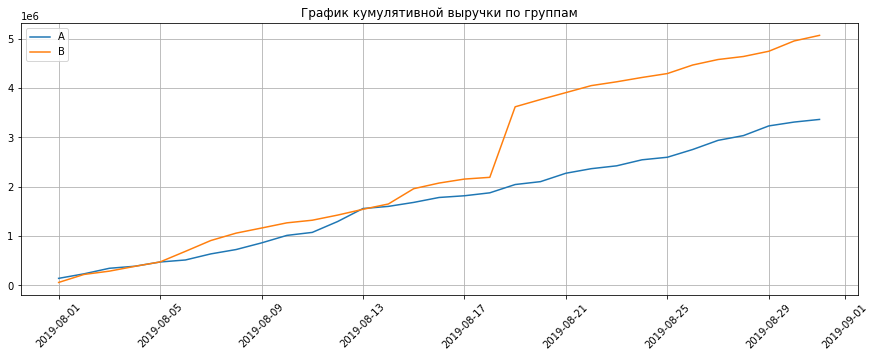

In [18]:
# Создадим список из уникальных значений дат и групп.
datesGroups = orders[['date','group']].drop_duplicates().sort_values(by=['date', 'group'])

# Создадим агрегированные данные по orders
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'visitorId':'nunique', 'revenue':'sum'}), axis = 1)
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
# Создадим агрегированные данные по visitors
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)
# Объединим таблицы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.grid(True)

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xticks(rotation=45)
plt.legend() 
plt.show()

Группа В показывает более высокую куммулятивную выручку. Так же заметен резкий рост выручки в районе 2019-08-18 по группе В, возможно это выброс.

<a id='12'></a>
##### 	Построим график кумулятивного среднего чека по группам

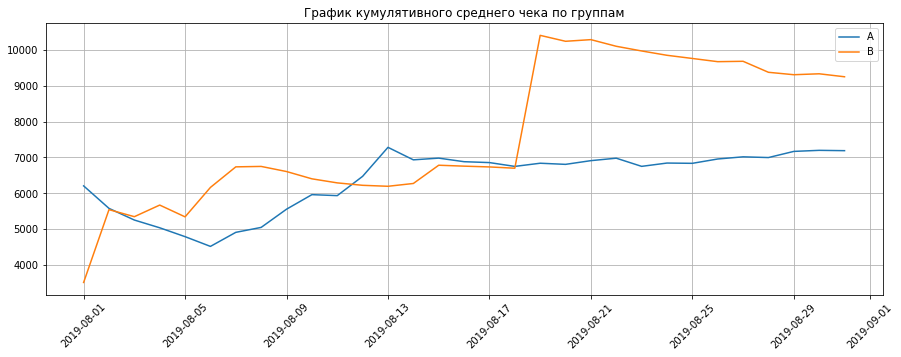

In [19]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.xticks(rotation=45)
plt.legend()
plt.show()

До 2019-08-18 средние чеки по группе В и группе А поочередно меняли лидерство, хотя визуально группа В бла в лидерах подольше.. Но 2019-08-18 произошел резкий скачек роста чека по группе В, после этого средний чек группы А остался примерно стабильным, а средний чек группы В после резкого взлета начал плавно снижаться. Резкий рост среднего чека группы В от 2019-08-18, является аномальным и вероятно обусловлен выбросами.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Да, тут так-же группа В выделяется.
</div>

<a id='13'></a>
##### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

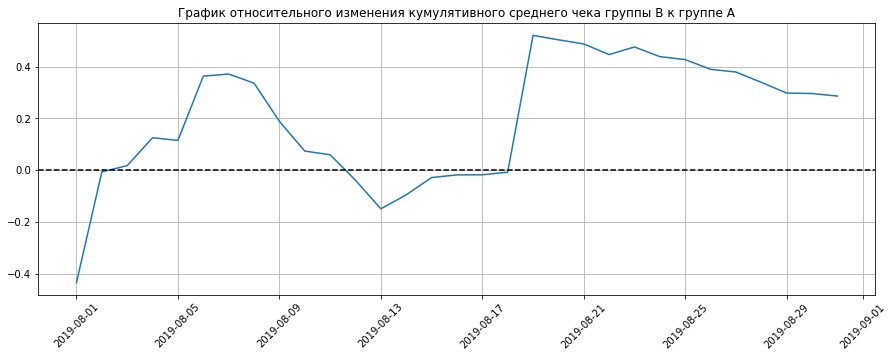

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on='date',
                                                   how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

В целом большее время, за весь эксперимент, средний чек группы В превышал чек группы А. Видим резкие изменения в среднем чеке В относительно А. Резкий рост в районе 2019-08-18. Вероятно это связано с аномалиями.

<a id='14'></a>
#####  Построим график кумулятивного среднего количества заказов на посетителя по группам

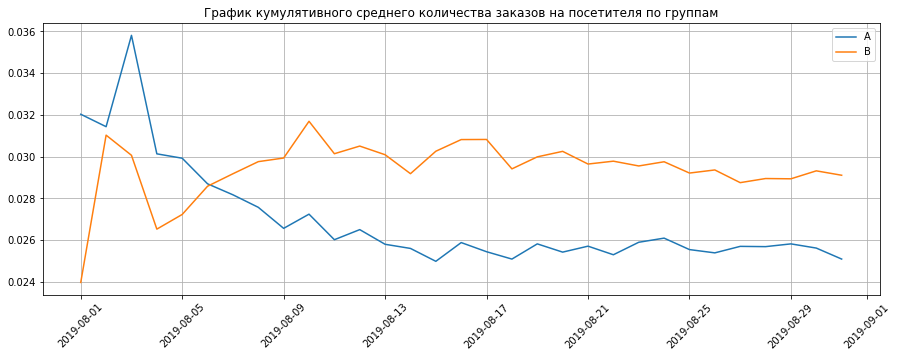

In [21]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Кумулятивное среднее количество заказов группы В с 2019-08-06 стабильно выше чем у группы А. Группа В лидирует по заказам на посетителя до конца эксперимента.

<a id='15'></a>
#####  Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

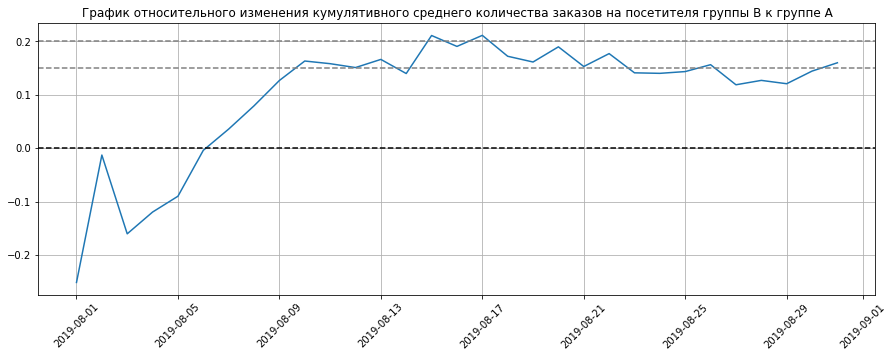

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], \
                              left_on='date', right_on='date', how='outer', suffixes=['A', 'B'])

plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] \
         /mergedCumulativeConversions['conversionA']-1)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.show()

C 2019-08-06 относительный прирост среднего количества заказов по группе В возрастает к группе А. В конце исследования группа В обгоняет группу А на 16 процентов. В целом с 2019-08-06 группа В превосходит группу А стабильно более чем на 10%.

<a id='16'></a>
##### Построим точечный график количества заказов по пользователям.

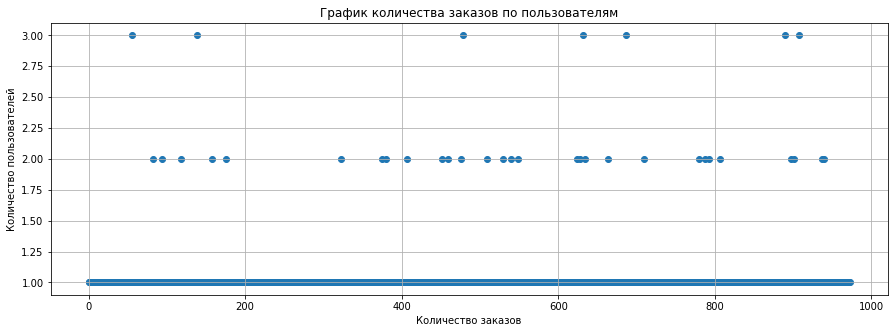

In [23]:
# Найдем число заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(15, 5))
plt.grid(True)
plt.xlabel('Количество заказов') 
plt.ylabel('Количество пользователей') 
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Большинство посетителей интернет-магазина совершает один заказ. Чуть чаще пользователи совершают два заказа. Более двух заказов это достаточно редкое явление. 

<a id='17'></a>
##### Посчитаем 90-й, 95-й и 99-й перцентили количества заказов на пользователя

In [24]:
percent = np.percentile(ordersByUsers['orders'], [90, 95, 99])
print('Перцентили: \n90: {} \n95: {}\n99: {}'.format(percent[0],percent[1], percent[2]))

Перцентили: 
90: 1.0 
95: 1.0
99: 2.0


Только 1 процент посетителей совершают более 2 заказов. Два заказа будет нашим лимитом по ограничению выбросов по количеству заказов.

<a id='18'></a>
##### Построим точечный график стоимостей заказов

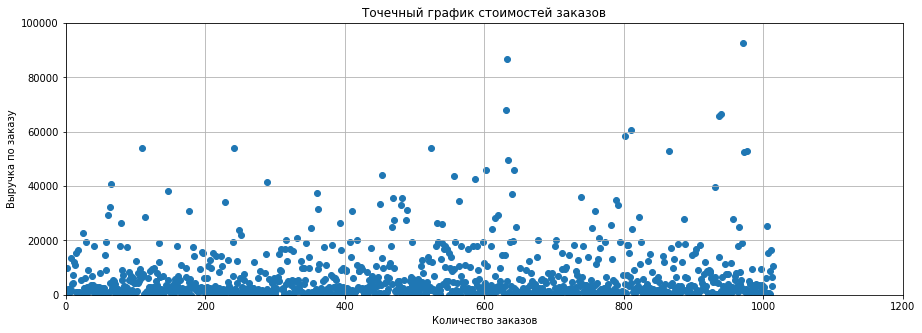

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(15, 5))
plt.grid(True)
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Количество заказов') 
plt.ylabel('Выручка по заказу') 
plt.title('Точечный график стоимостей заказов')
plt.axis([0, 1200, 0, 100000])
plt.show()

Судя по графику выручка подавляющего большинства заказов не превышает 20000. Более подробно рассмотрим через перцентили.

<a id='19'></a>
##### Посчитаем 90-й, 95-й и 99-й перцентили стоимости заказов

In [26]:
percent = np.percentile(orders['revenue'], [90, 95, 99])
print('Перцентили: \n90: {:.0f} \n95: {:.0f}\n99: {:.0f}'.format(percent[0],percent[1], percent[2]))

Перцентили: 
90: 17990 
95: 26785
99: 53904


Десять процентов пользователей тратит более 17990 на один заказ. Пять процентов пользователей тратят более 26785 на заказ. Сумму свыше 53904 тратят на заказ только один процент пользователей.

<a id='20'></a>
##### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по "сырым" данным

Нулевая гипотеза (H0): между конверсиями групп A и B нет статистически значимых различий.<br>
Альтернативная гипотеза (H1): конверсия в группе B статистически значимо отличается от конверсии в группе A.

In [27]:
# Создаем DataFrame ordersByUsersA, содержащий число заказов для каждого пользователя из группы A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

# Создаем DataFrame ordersByUsersB, содержащий число заказов для каждого пользователя из группы B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# Создаем DataFrame visitorsADaily, содержащий количество посетителей для каждой даты в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Создаем sampleA, содержащий количество заказов для каждого пользователя в группе A и нулевые значения 
# для пользователей, которые не совершили заказы
sampleA = pd.concat(
    [
        ordersByUsersA['orders'], # Количество заказов для каждого пользователя
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Создаем DataFrame visitorsBDaily, содержащий количество посетителей для каждой даты в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Создаем sampleB, содержащий количество заказов для каждого пользователя в группе B и нулевые значения 
# для пользователей, которые не совершили заказы
sampleB = pd.concat(
    [
        ordersByUsersB['orders'], # Количество заказов для каждого пользователя
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Выводим p-value, вычисленное по тесту Манна-Уитни
print("P-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

# Выводим относительное изменение конверсии группы B к конверсии группы A в процентах
print("Относительный прирост среднего группы B к конверсии группы A: {0:.1f}%". \
      format((sampleB.mean() / sampleA.mean() - 1) * 100))


P-value: 0.01096
Относительный прирост среднего группы B к конверсии группы A: 16.0%


Возьмем за уровень значимости 0.05. P-Value получается 0.01. Что ниже нашего уровня значимости, это говорит о том что гипотезу о равенстве среднего количества заказов между группами можно отклонить. Есть статистически значимая разница между средним количеством заказов в А и В группах.

<a id='21'></a>
##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "сырым" данным

Нулевая гипотеза (H0): между средними чеками групп A и B нет статистически значимых различий.<br>
Альтернативная гипотеза (H1): средний чек в группе B статистически значимо отличается от чека в группе A.

In [28]:
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                                  orders[orders['group']=='B']['revenue'])[1]))
relative_difference = (
    orders[orders['group']=='B']['revenue'].mean() /
    orders[orders['group']=='A']['revenue'].mean() - 1
) * 100

print('Относительное различие среднего чека между группами: {0:.3f}%'.format(relative_difference))


P-value: 0.829
Относительное различие среднего чека между группами: 28.660%


Относительное различие среднего чека между группами В и А равно 28.66 %. Но согласно статистическому тесту между средним чеком в этих двух группах нет статистически значимых различий, то есть вероятно такое различие в средних чеках может быть связано с выбросами. Нулевую гипотезу мы не отвергаем, на то нет статистических оснований.

<a id='22'></a>
##### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по "очищенным" данным

Нулевая гипотеза (H0): между конверсиями групп A и B нет статистически значимых различий.<br>
Альтернативная гипотеза (H1): конверсия в группе B статистически значимо отличается от конверсии в группе A.

In [29]:
# Установим ограничения по количеству заказов и среднему чеку, что бы очистить данные от выбросов.
limit_orders = 2
limit_revenue = 26785

# Выделим аномальные данные
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > limit_orders]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > limit_orders]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > limit_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# Очистим данные от аномалий, путем исключения выбросов.
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Произведем расчет статистики
print('P-Value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Прирост сегмента В относительно сегмента А: {0:.2f}%'. \
      format((sampleBFiltered.mean()/sampleAFiltered.mean()-1) *100) )

P-Value: 0.01229
Прирост сегмента В относительно сегмента А: 18.20%


Возьмем за уровень значимости 0.05. Видим прирост среднего количества заказов по группе В относительно группы А на 18.2%. P-Value ниже уровня значимости, это говорит о статистически значимых различиях между группами по количеству заказов. Нулевую гипотезу отвергаем в пользу альтернативной. Конверсия группы В выше чем конверсия группы А и это подтверждает статистический тест.

<a id='23'></a>
##### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "очищенным" данным

Нулевая гипотеза (H0): между средними чеками групп A и B нет статистически значимых различий.<br>
Альтернативная гипотеза (H1): средний чек в группе B статистически значимо отличается от чека в группе A.

In [30]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительное различие между группами В и А по среднему чеку: {0:.2f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.646
Относительное различие между группами В и А по среднему чеку: -0.05


Возьмем за уровень значимости 0.05. Средний чек группы В по очищенным данным снизился на 2 процента к группе А. P-Value гораздо выше уровня значимости. Это говорит о том, что между очищенными данными нет статистически значимых различий в среднем чеке между группами. Мы не можем отвергнуть нулевую гипотезу. 

<a id='24'></a>
#### Примем решение по результатам теста. Сделаем вывод.

<strong>У нас есть три варианта дальнейшего развития событий:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.</strong>

<strong>Мы увидели разницу в конверсии между А и В группами. По "неочищенным данным" прирост конверсии группы В относительно группы А был 16 процентов. Прирост конверсии группы В по "очищенным" данным был на 18.2 процента.

Касательно средних чеков ситуация следующая. По "сырым" данным статистически важных различий нет. Но, относительное различие среднего чека между группами: 28.66%. По "очищенным" данным - относительное различие между группами В и А по среднему чеку: -2%. Статистически значимых различий между средними чеками двух групп нет. Имеет место быть выбросы - единичные особо крупные покупки, вляющие на среднее значение.

Поскольку наша выборка по количеству участников группы соотвествует необходимой выборке, согласно калькулятору Эвана Миллера. Думаю, что тест стоит остановить, так как через наш эксперимент прошло необходимое число людей, доли участников групп были равномерными.

Далее рассмотрим итоги тестов, по конверсии видим явную победу группы В, по среднему чеку - паритет.
Наша задача была увеличение выручки. Увеличение конверсии, даже при стабильности среднего чека, дает нам увеличение выручки, ввиду роста количества заказов. В этом случае, после остановки теста, можно зафиксировать победу группы В.

Наш А/В тест можно считать успешным, мы получили статистически значимые результаты, подверждающие эффективность наших гипотетических изменений в интернет-магазине. Мы добились нашей цели - увеличения выручки.</strong>